CIFAR10 데이터셋으로 오토인코더를 학습시켜 봅시다.

train_images <class 'numpy.ndarray'> (50000, 32, 32, 3) uint8
test_images <class 'numpy.ndarray'> (10000, 32, 32, 3) uint8


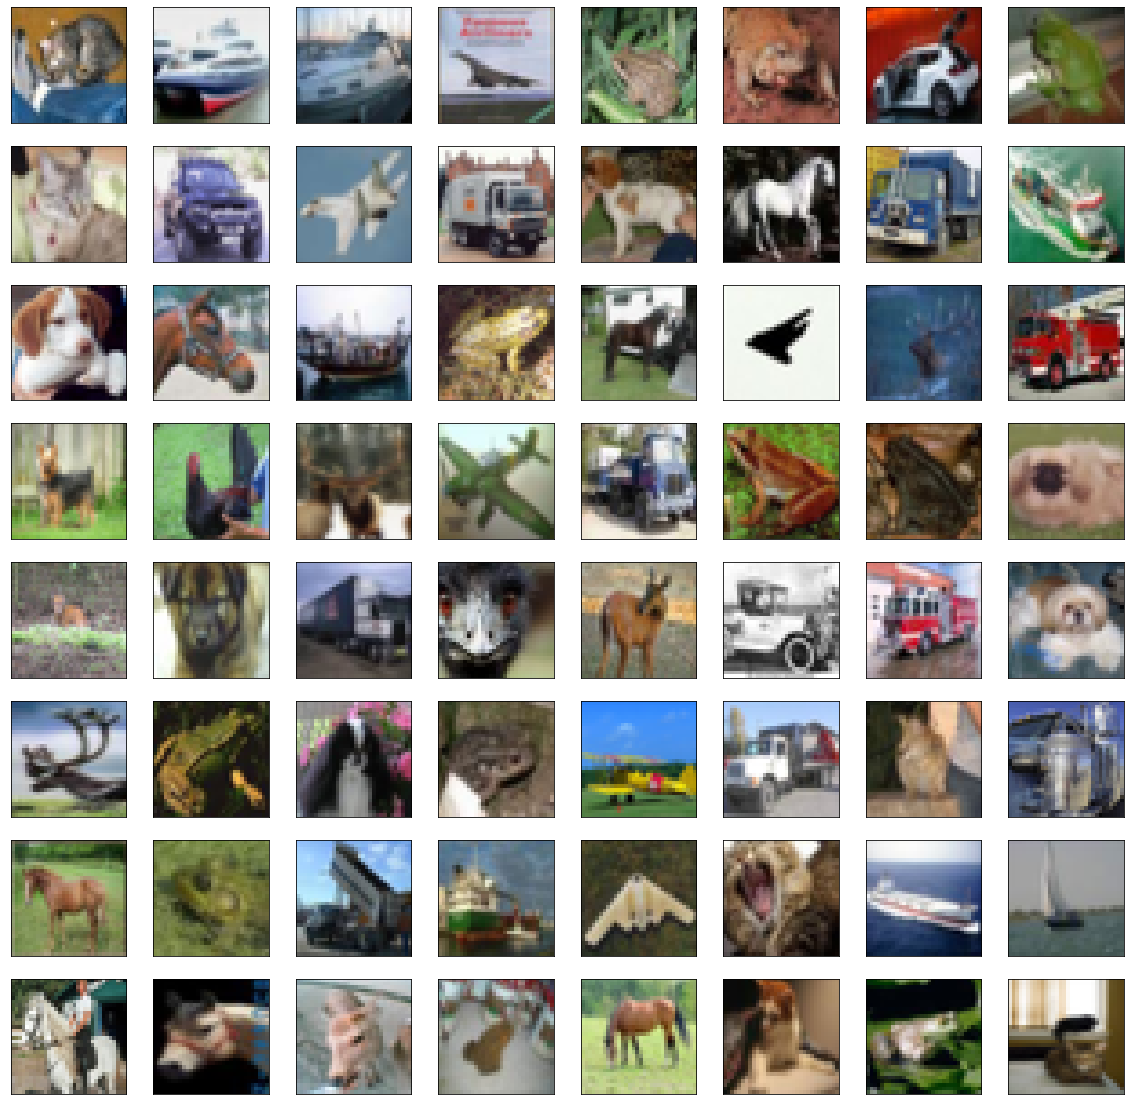

In [1]:
from tensorflow.keras import datasets, layers, models, utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

(train_images, _), (test_images, _) = datasets.cifar10.load_data()

print( 'train_images', type(train_images), train_images.shape, train_images.dtype )
print( 'test_images', type(test_images), test_images.shape, test_images.dtype )

plt.figure( figsize=(20,20) )
for i in range(0, 8*8):
    plt.subplot(8,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( test_images[i] )

다음과 같이 입력 데이터의 전처리를 해줍니다.

In [2]:
_, H, W, C = train_images.shape
train_x = ( train_images / 255 ).astype('float32')
test_x = ( test_images / 255 ).astype('float32')
print( 'test_x', type(test_x), test_x.shape, test_x.dtype )

test_x <class 'numpy.ndarray'> (10000, 32, 32, 3) float32


인코더, 디코더, 그 둘을 합쳐 오토 인코더를 만듭니다. 

In [3]:
x = layers.Input(shape=(H,W,C), name='x')
e = layers.Conv2D(32, (3,3), padding='same', activation='relu', name='e1')(x)
e = layers.MaxPooling2D((2, 2), name='e2')(e)
e = layers.Conv2D(64, (3,3), padding='same', activation='relu', name='e3')(e)
e = layers.MaxPooling2D((2, 2), name='e4')(e)
e = layers.Conv2D(32, (3,3), padding='same', activation='relu', name='e5')(e)
z = layers.Conv2D(3, (3,3), padding='same', activation='relu', name='z')(e)
encoder = models.Model(x, z)

z = layers.Input(shape=encoder.get_layer('z').output_shape[1:], name = 'z')
d = layers.Conv2D(32, (3,3), padding='same', activation='relu', name='d1')(z)
d = layers.UpSampling2D((2, 2), name='d2')(d)
d = layers.Conv2D(64, (3,3), padding='same', activation='relu', name='d3')(d)
d = layers.UpSampling2D((2, 2), name='d4')(d)
d = layers.Conv2D(32, (3,3), padding='same', activation='relu', name='d5')(d)
y = layers.Conv2D(3, (3,3), padding='same', activation=None, name='y')(d)
decoder = models.Model(z, y)

autoencoder = models.Sequential()
autoencoder.add( encoder )
autoencoder.add( decoder )

encoder.summary()
decoder.summary()
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 32, 32, 3)]       0         
_________________________________________________________________
e1 (Conv2D)                  (None, 32, 32, 32)        896       
_________________________________________________________________
e2 (MaxPooling2D)            (None, 16, 16, 32)        0         
_________________________________________________________________
e3 (Conv2D)                  (None, 16, 16, 64)        18496     
_________________________________________________________________
e4 (MaxPooling2D)            (None, 8, 8, 64)          0         
_________________________________________________________________
e5 (Conv2D)                  (None, 8, 8, 32)          18464     
_________________________________________________________________
z (Conv2D)                   (None, 8, 8, 3)           867   

모델을 학습하고 검증합니다.

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 15s 334us/sample - loss: 0.0212 - accuracy: 0.4986 - val_loss: 0.0086 - val_accuracy: 0.6244ss: 0.0215 - accura
Epoch 2/20
45000/45000 [==============================] - 12s 273us/sample - loss: 0.0075 - accuracy: 0.6844 - val_loss: 0.0063 - val_accuracy: 0.7345
Epoch 3/20
45000/45000 [==============================] - 12s 273us/sample - loss: 0.0062 - accuracy: 0.7377 - val_loss: 0.0059 - val_accuracy: 0.7559
Epoch 4/20
45000/45000 [==============================] - 12s 275us/sample - loss: 0.0057 - accuracy: 0.7469 - val_loss: 0.0056 - val_accuracy: 0.7596
Epoch 5/20
45000/45000 [==============================] - 12s 276us/sample - loss: 0.0053 - accuracy: 0.7514 - val_loss: 0.0050 - val_accuracy: 0.7653
Epoch 6/20
45000/45000 [==============================] - 12s 275us/sample - loss: 0.0051 - accuracy: 0.7521 - val_loss: 0.0059 - val_accuracy: 0.7554
Epoch 7/20
45000/45000 [==

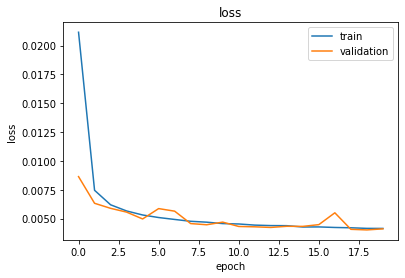

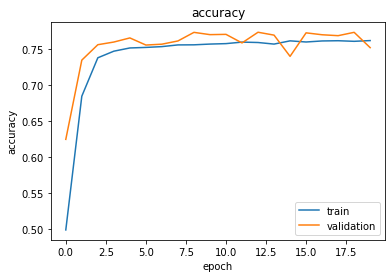

10000/10000 [==============================] - 1s 121us/sample - loss: 0.0041 - accuracy: 0.7529
[loss, accuracy] = [0.004130259446799755, 0.752882]


In [4]:
hist = autoencoder.fit(train_x, train_x, epochs=20, batch_size=128, validation_split=0.1)

from modules.plot_history import plot_history
plot_history(hist, 'loss')
plot_history(hist, 'accuracy')

performance_test = autoencoder.evaluate(test_x, test_x, batch_size=128)
print( '[loss, accuracy] =', performance_test )

입력이미지를 인코딩하고 그 인코딩 된 값을 디코딩하여 원래 이미지와 비슷하게 복원되는지 확인합시다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


encoded_imgs.shape = (10000, 8, 8, 3)
decoded_imgs.shape = (10000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


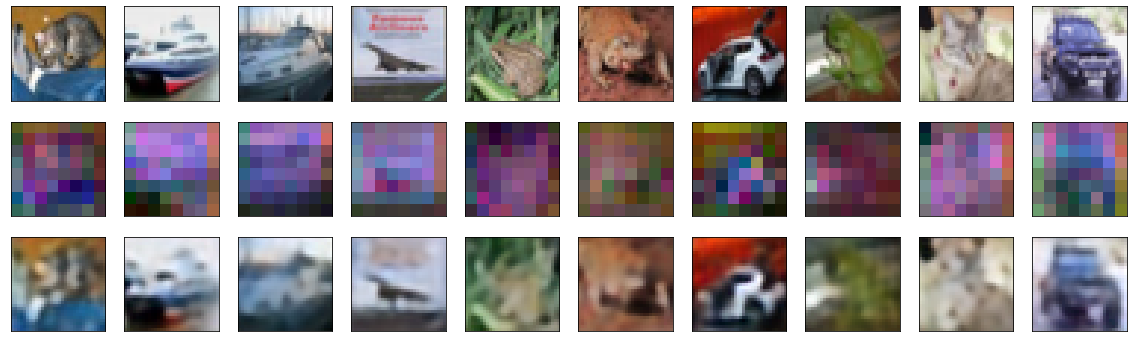

In [5]:
encoded_imgs = encoder.predict(test_x)
decoded_imgs = decoder.predict(encoded_imgs)

print( 'encoded_imgs.shape =', encoded_imgs.shape )
print( 'decoded_imgs.shape =', decoded_imgs.shape )

n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(test_x[i])

    plt.subplot(3, n, i + 1 + n)
    plt.xticks([]); plt.yticks([])
    plt.imshow(encoded_imgs[i]*0.6)

    plt.subplot(3, n, i + 1 + n + n)
    plt.xticks([]); plt.yticks([])
    plt.imshow(decoded_imgs[i])

plt.show()

노이즈가 첨가된 입력 이미지가 들어가면 노이즈가 제거가 되는 이미지가 출력되는것을 알 수 있습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


encoded_imgs.shape = (10000, 8, 8, 3)
decoded_imgs.shape = (10000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


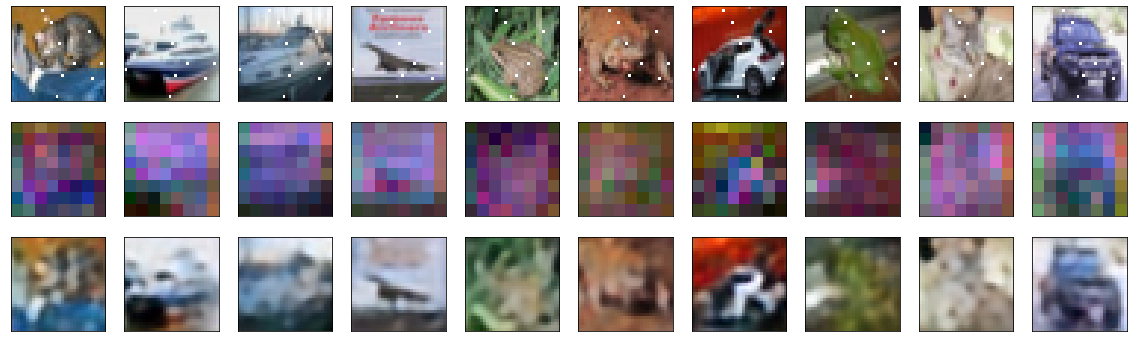

In [6]:
noise = np.zeros((H,W,C), dtype=np.float32)
num_noise_points = 10
noise_posx = np.random.randint(0, W, num_noise_points)
noise_posy = np.random.randint(0, H, num_noise_points)
for i in range(num_noise_points):
    noise[noise_posy[i], noise_posx[i]] = (1,1,1)

test_x_noise = np.clip(test_x + noise, 0, 1)

encoded_imgs = encoder.predict(test_x_noise)
decoded_imgs = decoder.predict(encoded_imgs)

print( 'encoded_imgs.shape =', encoded_imgs.shape )
print( 'decoded_imgs.shape =', decoded_imgs.shape )

plt.figure(figsize=(20, 6))

for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(test_x_noise[i])

    plt.subplot(3, n, i + 1 + n)
    plt.xticks([]); plt.yticks([])
    plt.imshow(encoded_imgs[i]*0.6)

    plt.subplot(3, n, i + 1 + n + n)
    plt.xticks([]); plt.yticks([])
    plt.imshow(decoded_imgs[i])

plt.show()